# Modelo Predicción de Ocupación

## Contenido
* Parámetros generales e Importacion de biblioticas
* Carga de los datos
* Parámetros Generales
* Preprocesamiento
 * Unificación 
* Modelo
 * Procesamiento
 * Tidy Table
 * Separación Xvar y Yvar  (número variable de periodo)
 * Separacion Train y Test
 * Configuración de los Modelos
 * Funciones 
  * F. para evaluar varios modelos
  * F. para categorizar en semáforo
  * F. Evaluación de resultados Exactitud
* Generacion de Pronosticos a futuro
 * Procesamiento entrada para pronóstico
 * Ejecución del modelos y archivo de entrega

### Alcance
* Unir archivos de 6 meses con historia,  exportar para ejecución pronóstico
* Entrenar y guardar modelos
* ESTE SCRIPT NO GENERA PRONOSTICOS FUTURO,  el script que lo realiza formatea la respuesta según lo solicitado.
* Según lo anterior el otro script debe ejecutarse despues de este.

## Parámetros generales e Importacion de biblioticas

In [53]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from datetime import datetime
from dateutil.relativedelta import relativedelta
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from xgboost import plot_importance
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix # es una manera para resumir los datos 
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve #roc_curve
from sklearn.metrics import roc_auc_score #auc
from joblib import dump,load

## Carga de los datos

In [55]:
data_ocupacionNodo = pd.read_csv('DatosOrigen/OCUPACION_NODO.csv', sep=';')
data_NodoINFI = pd.read_csv('DatosOrigen/NODO_INFI.csv', sep=';')
data_SEG = pd.read_csv('DatosOrigen/segmentacion.csv', sep=';') 

### Unir datos

### Base data_NodoINF

In [56]:
data_NodoINFI['DIA']=1 # le agrego la columna dia
data_NodoINFI['MES'] = [f'0{x}' if x <10 else str(x) for x in data_NodoINFI['MES']]
data_NodoINFI['DIA'] = [f'0{x}' if x <10 else str(x) for x in data_NodoINFI['DIA']]
data_NodoINFI['FECHA'] = (2000+data_NodoINFI['ANIO']).astype('str') + '-' + data_NodoINFI['MES'] + '-' + data_NodoINFI['DIA']
# eliminamos columnas sobrantes
data_NodoINFI=data_NodoINFI.drop(['DIA','MES','ANIO'], axis=1)
# # renombramos columnas
data_NodoINFI.rename(columns={'NODO':'COD_NODO'}, inplace=True)
### completar Nullos con 0
data_NodoINFI=data_NodoINFI.fillna(0)

### Base data_NodoINF data_SEG

In [57]:
data_SEG.drop(['NUEVA ESTRUCTURA'], axis=1,inplace=True)
data_SEG['SEGMENTADO']=1

## Preprocesamiento
### Unificacion

In [58]:
data_ocupacion=pd.merge(data_ocupacionNodo, data_NodoINFI, on = ('COD_NODO','FECHA'), how='left')
data_ocupacion=pd.merge(data_ocupacion, data_SEG, on = ('COD_NODO','FECHA'), how='left')

### Parámetros generales

In [59]:
start = datetime.now()

In [60]:
fechaMaxima=datetime.strptime(data_ocupacion['FECHA'].max(),'%Y-%m-%d')
periodos_y=7
periodos_x=7
variable_prediccion='OCUPACION_DW'

In [61]:
fechaLimite=fechaMaxima + relativedelta(months=-1*periodos_y)
fechaInicial=fechaLimite + relativedelta(months=-1*periodos_x)

### Selección Fechas

In [62]:
## Eliminar informaición anterior Junion 2022
data_ocupacion['FECHA']=data_ocupacion['FECHA'].astype('datetime64[ns]')
### Elininar datos últimos mes
data_ocupacion=data_ocupacion[data_ocupacion['FECHA']>=fechaInicial]
### Eliminar Fecha Final  (mes incompleto)
data_ocupacion=data_ocupacion[data_ocupacion['FECHA']<fechaMaxima]

##  Funciones

In [63]:
#Funcion para Calcular el número de periodos hacia atrás
def diff_month(d1, d2):
    return (d1.year - d2.dt.year) * 12 + d1.month - d2.dt.month

In [64]:
def semaforo(df, col):
    df = df.copy()
    df.loc[(df[col]>=0.58) & (df[col]<=0.75), 'ESTATUS'] = 'AMARILLO'
    df.loc[df[col]>0.75, 'ESTATUS'] = 'ROJO'
    df.loc[df[col]<0.60, 'ESTATUS'] = 'VERDE'
    return(df)

In [65]:
def semaforoVal(val):
    #df = df.copy()
    respuesta='V'
    if (val>=0.58) & (val<=0.75):
        respuesta='A'
    elif val>0.75:
        respuesta='R'
    return(respuesta)

In [66]:
def semaforoNum2Val(val):   
    respuesta='V'
    if val==1:
        respuesta='A'
    elif val==2:
        respuesta='R'
    return(respuesta)

In [67]:
def semaforoVal2Num(val):   
    respuesta=0
    if val=='A':
        respuesta=1
    elif val=='R':
        respuesta=2
    return(respuesta)

In [68]:
def semaforoRojo(val):    
    if val>0.75:
        respuesta=1
    else :
        respuesta=0
    return(respuesta)

In [69]:
def semaforoAmarillo(val):    
    if (val>=0.58) & (val<=0.75):
        respuesta=1
    else :
        respuesta=0
    return(respuesta)

In [70]:
def semaforoRojoAmarillo(val):    
    if val>=0.58:
        respuesta=1
    else :
        respuesta=0
    return(respuesta)

In [71]:
def semaforoNum(val):
    #df = df.copy()
    respuesta=0
    if (val>=0.58) & (val<=0.75):
        respuesta=1
    elif val>0.75:
        respuesta=2
    return(respuesta)

In [72]:
def semaforoNum2Rojo(val):    
    respuesta=0
    if val==2:
        respuesta=1    
    return(respuesta)

In [73]:
def semaforoNum2Amarillo(val):    
    respuesta=0
    if val==1:
        respuesta=1    
    return(respuesta)

In [74]:
def semaforoNum2RojoAmarillo(val):    
    respuesta=0
    if val>=1:
        respuesta=1    
    return(respuesta)

In [75]:
def medidasEvaluacion(matrizConfucion):
    exactitud=np.trace(matrizConfucion)/matrizConfucion.sum()
    print ('exactitud:', exactitud)
    sensibilidad=[0]*3
    especificidad=[0]*3
    for i in range(0,len(matrizConfucion)):
        sensibilidad[i]=matrizConfucion[i,i]/matrizConfucion.sum(axis=1)[i]
        especificidad[i]=np.delete(np.delete(matrizConfucion,i, axis=0),i,axis=1).sum()/np.delete(matrizConfucion,i, axis=0).sum()
        print ('sensibilidad ',i,": ",sensibilidad[i])
        print ('especificidad ',i,": ",especificidad[i])

In [76]:
def sampling_strategy(X,y,n_samples,t='majority'):
    target_classes=''
    if t== 'majority':
        target_classes= y.value_counts() >n_samples
    elif t== 'minority':
        target_classes = y.value_counts() < n_samples
    tc=target_classes[target_classes ==True].index
    #target_classes_all=y.value_counts().index
    sampling_strategy={}
    for target in tc:
        sampling_strategy[target]= n_samples
    return sampling_strategy

In [77]:
def df2Feature_importanceClass(x_train_b,mod,title):
    #shap_test = x_train_b.sample(1000)
    shap_test = x_train_b
    shap_values = shap.TreeExplainer(mod).shap_values(shap_test)
    plt.figure()
    plt.title(title)
    shap.summary_plot(shap_values, shap_test,max_display=30)
    plt.subplots_adjust(left=0.35, right=0.9, top=0.9, bottom=0.3)    
    plt.show();

## Modelo
### Procesamiento

In [78]:
data_ocupacion['mesAnt']=(periodos_x+periodos_y)-diff_month(fechaMaxima,data_ocupacion['FECHA'])
### Ordenar por fecha
data_ocupacion=data_ocupacion.sort_values(["FECHA","COD_NODO"], ascending = (True, True))

### Seleccion Nodos para el Modelo

In [79]:
### Solo Nodos con información completa
seleccion=data_ocupacion[['COD_NODO',variable_prediccion]].groupby('COD_NODO').count()
seleccion[seleccion[variable_prediccion]>=periodos_y+periodos_x+1]
seleccion.rename(columns={variable_prediccion:'noRegVarPre'}, inplace=True)
data_ocupacion=data_ocupacion.merge(seleccion, on='COD_NODO', how='left')
data_ocupacion=data_ocupacion[data_ocupacion['noRegVarPre']>=periodos_y+periodos_x]
data_ocupacion.drop(columns='noRegVarPre', inplace=True)
### Nodos No Segmentados en el periodo de tiempo considerado
data_ocupacion=data_ocupacion[data_ocupacion['SEGMENTADO']!=1]
data_ocupacion.drop(columns='SEGMENTADO', inplace=True)
### Eliminar datos con nullos
data_ocupacion=data_ocupacion.dropna()

###  Selección Columnas

In [80]:
selCols=['COD_NODO','FECHA','OCUPACION_DW','OCUPACION_UP','SERV_INT','mesAnt']
data_ocupacionC=data_ocupacion.copy()
data_ocupacion=data_ocupacion[selCols]

### Tidy Tables

#### Regresión

In [81]:
cols=data_ocupacion.columns
cols=cols[2:-1]

In [83]:
cols

Index(['OCUPACION_DW', 'OCUPACION_UP', 'SERV_INT'], dtype='object')

In [84]:
cols_x=[]
for i, col in enumerate(cols):
    tablaAnalisis = pd.pivot_table(data_ocupacion.reset_index(), index='COD_NODO', columns='mesAnt', values=col)
    tablaAnalisis.rename(columns={x: (col+"-"+str(x)) for x in tablaAnalisis.columns}, inplace=True)
    #Identificacion Columnas X y Y    
    cols_x=cols_x+[(col+"-"+str(x)) for x in range(0,periodos_x)]    
    if i==0:
        tablaAnalisisTotal = tablaAnalisis
    else:
        tablaAnalisisTotal = tablaAnalisisTotal.merge(tablaAnalisis, how='outer', on='COD_NODO')

In [85]:
cols_x=sorted(list(set(cols_x)& set(tablaAnalisisTotal.columns.tolist())))

In [86]:
cols_y=[(variable_prediccion+"-"+str(x)) for x in range(periodos_x,periodos_x+periodos_y-1)]

In [87]:
tablaAnalisisTotal=tablaAnalisisTotal.dropna()

In [88]:
data_ocupacionC.head()

,COD_NODO,FECHA,OCUPACION_DW,OCUPACION_UP,CANT_USER,PROM_VEL,MEDIANA_VEL,VEL_ME_8,VEL_10_25,VEL_30,...,VEL_MAX,VEL_MIN,RENTA,PROM_RENTA,CONVERGENTE,SERV_INT,SERV_TV,SERV_VOZ,CANT_CALL,mesAnt
0,01J,2020-10-01,0.290939,0.212174,26.0,40.0,30.0,2.0,3.0,9.0,...,100.0,5.0,2694135.0,103621.0,6.0,26.0,21.0,18.0,1.0,0
1,01S,2020-10-01,0.358060,0.219646,146.0,34.0,30.0,46.0,6.0,30.0,...,150.0,5.0,13139893.0,89999.0,77.0,146.0,109.0,120.0,21.0,0
3,02J,2020-10-01,0.290939,0.212174,9.0,44.0,45.0,0.0,2.0,0.0,...,100.0,10.0,951287.0,105699.0,4.0,9.0,6.0,8.0,2.0,0
4,02S,2020-10-01,0.358060,0.229191,116.0,28.0,30.0,36.0,12.0,29.0,...,100.0,5.0,10170582.0,87677.0,37.0,116.0,83.0,97.0,11.0,0
5,03J,2020-10-01,0.290939,0.212174,28.0,35.0,35.0,1.0,6.0,7.0,...,75.0,5.0,3101336.0,110762.0,12.0,28.0,26.0,24.0,4.0,0


#### Clasificación

In [89]:
colsC=data_ocupacionC.columns
colsC=colsC[2:-1]

In [90]:
cols_xC=[]
for i, col in enumerate(colsC):
    tablaAnalisis = pd.pivot_table(data_ocupacionC.reset_index(), index='COD_NODO', columns='mesAnt', values=col)
    tablaAnalisis.rename(columns={x: (col+"-"+str(x)) for x in tablaAnalisis.columns}, inplace=True)
    #Identificacion Columnas X y Y    
    cols_xC=cols_xC+[(col+"-"+str(x)) for x in range(0,periodos_x)]    
    if i==0:
        tablaAnalisisTotalC = tablaAnalisis
    else:
        tablaAnalisisTotalC = tablaAnalisisTotalC.merge(tablaAnalisis, how='outer', on='COD_NODO')
tablaAnalisisTotalC=tablaAnalisisTotalC.dropna()

In [91]:
cols_xC=sorted(list(set(cols_xC)& set(tablaAnalisisTotalC.columns.tolist())))

### Separación Xvar y Yvar (número variable de periodo)

In [92]:
Xvar=tablaAnalisisTotal[cols_x]
XvarC=tablaAnalisisTotalC[cols_xC]
yvar=tablaAnalisisTotal[cols_y]

In [93]:
for col in cols_y:    
    yvar[col+'_sem']=yvar[col].apply(semaforoRojo)
    yvar[col+'_sem2']=yvar[col].apply(semaforoNum)    

yColClass=[s + '_sem2' for s in cols_y]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Separacion Train y Test

In [94]:
X_train, X_test, y_train, y_test = train_test_split(Xvar, yvar, test_size = 0.3, random_state = 86, shuffle= True)

##  Modelos ML

### XGBRegressor

In [95]:
modelos={}
for yCol in cols_y:
    print(yCol)
    y_train_aux=y_train[yCol]
    y_test_aux=y_test[yCol]
    dicModelo={}        
    dicModelo['modelo']=xgb.XGBRegressor(max_depth=80, verbosity= 0, subsample=0.5,  n_estimators=472, n_jobs=-1, objective='reg:squarederror', booster='gbtree', random_state=42, learning_rate=0.04, reg_lambda=1)
    dicModelo['modelo'].fit(X_train, y_train_aux, eval_set=[(X_train, y_train_aux), (X_test, y_test_aux)])
    dicModelo['predictions'] = dicModelo['modelo'].predict(X_test)
    dicModelo['explanation']=shap.TreeExplainer(dicModelo['modelo'])    
    modelos[yCol]=dicModelo    

OCUPACION_DW-7
[0]	validation_0-rmse:0.16582	validation_1-rmse:0.16570
[1]	validation_0-rmse:0.15966	validation_1-rmse:0.15964
[2]	validation_0-rmse:0.15377	validation_1-rmse:0.15390
[3]	validation_0-rmse:0.14812	validation_1-rmse:0.14838
[4]	validation_0-rmse:0.14270	validation_1-rmse:0.14314
[5]	validation_0-rmse:0.13750	validation_1-rmse:0.13814
[6]	validation_0-rmse:0.13248	validation_1-rmse:0.13326
[7]	validation_0-rmse:0.12760	validation_1-rmse:0.12854
[8]	validation_0-rmse:0.12299	validation_1-rmse:0.12408
[9]	validation_0-rmse:0.11857	validation_1-rmse:0.11979
[10]	validation_0-rmse:0.11435	validation_1-rmse:0.11576
[11]	validation_0-rmse:0.11028	validation_1-rmse:0.11184
[12]	validation_0-rmse:0.10644	validation_1-rmse:0.10829
[13]	validation_0-rmse:0.10271	validation_1-rmse:0.10477
[14]	validation_0-rmse:0.09911	validation_1-rmse:0.10140
[15]	validation_0-rmse:0.09569	validation_1-rmse:0.09817
[16]	validation_0-rmse:0.09237	validation_1-rmse:0.09510
[17]	validation_0-rmse:0.0

[143]	validation_0-rmse:0.00752	validation_1-rmse:0.03914
[144]	validation_0-rmse:0.00741	validation_1-rmse:0.03914
[145]	validation_0-rmse:0.00732	validation_1-rmse:0.03913
[146]	validation_0-rmse:0.00725	validation_1-rmse:0.03914
[147]	validation_0-rmse:0.00717	validation_1-rmse:0.03913
[148]	validation_0-rmse:0.00709	validation_1-rmse:0.03911
[149]	validation_0-rmse:0.00700	validation_1-rmse:0.03911
[150]	validation_0-rmse:0.00692	validation_1-rmse:0.03911
[151]	validation_0-rmse:0.00685	validation_1-rmse:0.03912
[152]	validation_0-rmse:0.00676	validation_1-rmse:0.03910
[153]	validation_0-rmse:0.00669	validation_1-rmse:0.03909
[154]	validation_0-rmse:0.00662	validation_1-rmse:0.03908
[155]	validation_0-rmse:0.00655	validation_1-rmse:0.03906
[156]	validation_0-rmse:0.00647	validation_1-rmse:0.03906
[157]	validation_0-rmse:0.00639	validation_1-rmse:0.03905
[158]	validation_0-rmse:0.00632	validation_1-rmse:0.03905
[159]	validation_0-rmse:0.00624	validation_1-rmse:0.03904
[160]	validati

[426]	validation_0-rmse:0.00062	validation_1-rmse:0.03882
[427]	validation_0-rmse:0.00062	validation_1-rmse:0.03882
[428]	validation_0-rmse:0.00061	validation_1-rmse:0.03882
[429]	validation_0-rmse:0.00061	validation_1-rmse:0.03882
[430]	validation_0-rmse:0.00061	validation_1-rmse:0.03882
[431]	validation_0-rmse:0.00061	validation_1-rmse:0.03882
[432]	validation_0-rmse:0.00061	validation_1-rmse:0.03882
[433]	validation_0-rmse:0.00061	validation_1-rmse:0.03882
[434]	validation_0-rmse:0.00060	validation_1-rmse:0.03882
[435]	validation_0-rmse:0.00060	validation_1-rmse:0.03882
[436]	validation_0-rmse:0.00060	validation_1-rmse:0.03882
[437]	validation_0-rmse:0.00060	validation_1-rmse:0.03882
[438]	validation_0-rmse:0.00060	validation_1-rmse:0.03882
[439]	validation_0-rmse:0.00060	validation_1-rmse:0.03882
[440]	validation_0-rmse:0.00060	validation_1-rmse:0.03882
[441]	validation_0-rmse:0.00060	validation_1-rmse:0.03882
[442]	validation_0-rmse:0.00059	validation_1-rmse:0.03882
[443]	validati

[97]	validation_0-rmse:0.01952	validation_1-rmse:0.06292
[98]	validation_0-rmse:0.01927	validation_1-rmse:0.06288
[99]	validation_0-rmse:0.01901	validation_1-rmse:0.06286
[100]	validation_0-rmse:0.01879	validation_1-rmse:0.06282
[101]	validation_0-rmse:0.01856	validation_1-rmse:0.06277
[102]	validation_0-rmse:0.01832	validation_1-rmse:0.06277
[103]	validation_0-rmse:0.01808	validation_1-rmse:0.06276
[104]	validation_0-rmse:0.01786	validation_1-rmse:0.06268
[105]	validation_0-rmse:0.01764	validation_1-rmse:0.06265
[106]	validation_0-rmse:0.01740	validation_1-rmse:0.06262
[107]	validation_0-rmse:0.01719	validation_1-rmse:0.06260
[108]	validation_0-rmse:0.01699	validation_1-rmse:0.06257
[109]	validation_0-rmse:0.01679	validation_1-rmse:0.06256
[110]	validation_0-rmse:0.01656	validation_1-rmse:0.06255
[111]	validation_0-rmse:0.01637	validation_1-rmse:0.06257
[112]	validation_0-rmse:0.01619	validation_1-rmse:0.06256
[113]	validation_0-rmse:0.01597	validation_1-rmse:0.06252
[114]	validation_

[239]	validation_0-rmse:0.00408	validation_1-rmse:0.06178
[240]	validation_0-rmse:0.00404	validation_1-rmse:0.06178
[241]	validation_0-rmse:0.00400	validation_1-rmse:0.06178
[242]	validation_0-rmse:0.00396	validation_1-rmse:0.06177
[243]	validation_0-rmse:0.00392	validation_1-rmse:0.06177
[244]	validation_0-rmse:0.00388	validation_1-rmse:0.06177
[245]	validation_0-rmse:0.00385	validation_1-rmse:0.06178
[246]	validation_0-rmse:0.00381	validation_1-rmse:0.06178
[247]	validation_0-rmse:0.00378	validation_1-rmse:0.06177
[248]	validation_0-rmse:0.00374	validation_1-rmse:0.06177
[249]	validation_0-rmse:0.00370	validation_1-rmse:0.06177
[250]	validation_0-rmse:0.00367	validation_1-rmse:0.06177
[251]	validation_0-rmse:0.00363	validation_1-rmse:0.06176
[252]	validation_0-rmse:0.00359	validation_1-rmse:0.06176
[253]	validation_0-rmse:0.00356	validation_1-rmse:0.06176
[254]	validation_0-rmse:0.00353	validation_1-rmse:0.06175
[255]	validation_0-rmse:0.00350	validation_1-rmse:0.06175
[256]	validati

[381]	validation_0-rmse:0.00114	validation_1-rmse:0.06164
[382]	validation_0-rmse:0.00114	validation_1-rmse:0.06164
[383]	validation_0-rmse:0.00112	validation_1-rmse:0.06164
[384]	validation_0-rmse:0.00112	validation_1-rmse:0.06164
[385]	validation_0-rmse:0.00111	validation_1-rmse:0.06164
[386]	validation_0-rmse:0.00110	validation_1-rmse:0.06164
[387]	validation_0-rmse:0.00109	validation_1-rmse:0.06164
[388]	validation_0-rmse:0.00108	validation_1-rmse:0.06164
[389]	validation_0-rmse:0.00107	validation_1-rmse:0.06164
[390]	validation_0-rmse:0.00106	validation_1-rmse:0.06164
[391]	validation_0-rmse:0.00106	validation_1-rmse:0.06163
[392]	validation_0-rmse:0.00105	validation_1-rmse:0.06163
[393]	validation_0-rmse:0.00104	validation_1-rmse:0.06163
[394]	validation_0-rmse:0.00104	validation_1-rmse:0.06163
[395]	validation_0-rmse:0.00103	validation_1-rmse:0.06163
[396]	validation_0-rmse:0.00102	validation_1-rmse:0.06163
[397]	validation_0-rmse:0.00102	validation_1-rmse:0.06163
[398]	validati

[52]	validation_0-rmse:0.04100	validation_1-rmse:0.07007
[53]	validation_0-rmse:0.04023	validation_1-rmse:0.06980
[54]	validation_0-rmse:0.03951	validation_1-rmse:0.06959
[55]	validation_0-rmse:0.03882	validation_1-rmse:0.06938
[56]	validation_0-rmse:0.03813	validation_1-rmse:0.06915
[57]	validation_0-rmse:0.03745	validation_1-rmse:0.06896
[58]	validation_0-rmse:0.03679	validation_1-rmse:0.06874
[59]	validation_0-rmse:0.03614	validation_1-rmse:0.06853
[60]	validation_0-rmse:0.03556	validation_1-rmse:0.06834
[61]	validation_0-rmse:0.03498	validation_1-rmse:0.06823
[62]	validation_0-rmse:0.03439	validation_1-rmse:0.06805
[63]	validation_0-rmse:0.03383	validation_1-rmse:0.06789
[64]	validation_0-rmse:0.03329	validation_1-rmse:0.06777
[65]	validation_0-rmse:0.03268	validation_1-rmse:0.06765
[66]	validation_0-rmse:0.03212	validation_1-rmse:0.06751
[67]	validation_0-rmse:0.03164	validation_1-rmse:0.06739
[68]	validation_0-rmse:0.03113	validation_1-rmse:0.06729
[69]	validation_0-rmse:0.03065	

[195]	validation_0-rmse:0.00681	validation_1-rmse:0.06410
[196]	validation_0-rmse:0.00673	validation_1-rmse:0.06409
[197]	validation_0-rmse:0.00667	validation_1-rmse:0.06408
[198]	validation_0-rmse:0.00660	validation_1-rmse:0.06408
[199]	validation_0-rmse:0.00653	validation_1-rmse:0.06407
[200]	validation_0-rmse:0.00646	validation_1-rmse:0.06407
[201]	validation_0-rmse:0.00640	validation_1-rmse:0.06406
[202]	validation_0-rmse:0.00632	validation_1-rmse:0.06406
[203]	validation_0-rmse:0.00626	validation_1-rmse:0.06406
[204]	validation_0-rmse:0.00620	validation_1-rmse:0.06406
[205]	validation_0-rmse:0.00614	validation_1-rmse:0.06406
[206]	validation_0-rmse:0.00608	validation_1-rmse:0.06406
[207]	validation_0-rmse:0.00602	validation_1-rmse:0.06405
[208]	validation_0-rmse:0.00596	validation_1-rmse:0.06405
[209]	validation_0-rmse:0.00590	validation_1-rmse:0.06404
[210]	validation_0-rmse:0.00584	validation_1-rmse:0.06403
[211]	validation_0-rmse:0.00579	validation_1-rmse:0.06402
[212]	validati

[337]	validation_0-rmse:0.00179	validation_1-rmse:0.06386
[338]	validation_0-rmse:0.00178	validation_1-rmse:0.06386
[339]	validation_0-rmse:0.00176	validation_1-rmse:0.06386
[340]	validation_0-rmse:0.00174	validation_1-rmse:0.06386
[341]	validation_0-rmse:0.00173	validation_1-rmse:0.06386
[342]	validation_0-rmse:0.00172	validation_1-rmse:0.06386
[343]	validation_0-rmse:0.00170	validation_1-rmse:0.06386
[344]	validation_0-rmse:0.00169	validation_1-rmse:0.06386
[345]	validation_0-rmse:0.00167	validation_1-rmse:0.06386
[346]	validation_0-rmse:0.00166	validation_1-rmse:0.06386
[347]	validation_0-rmse:0.00164	validation_1-rmse:0.06386
[348]	validation_0-rmse:0.00163	validation_1-rmse:0.06386
[349]	validation_0-rmse:0.00161	validation_1-rmse:0.06386
[350]	validation_0-rmse:0.00160	validation_1-rmse:0.06386
[351]	validation_0-rmse:0.00159	validation_1-rmse:0.06386
[352]	validation_0-rmse:0.00158	validation_1-rmse:0.06386
[353]	validation_0-rmse:0.00156	validation_1-rmse:0.06386
[354]	validati

[7]	validation_0-rmse:0.13025	validation_1-rmse:0.13453
[8]	validation_0-rmse:0.12642	validation_1-rmse:0.13132
[9]	validation_0-rmse:0.12273	validation_1-rmse:0.12823
[10]	validation_0-rmse:0.11910	validation_1-rmse:0.12528
[11]	validation_0-rmse:0.11567	validation_1-rmse:0.12257
[12]	validation_0-rmse:0.11241	validation_1-rmse:0.11993
[13]	validation_0-rmse:0.10919	validation_1-rmse:0.11751
[14]	validation_0-rmse:0.10611	validation_1-rmse:0.11511
[15]	validation_0-rmse:0.10311	validation_1-rmse:0.11289
[16]	validation_0-rmse:0.10028	validation_1-rmse:0.11072
[17]	validation_0-rmse:0.09755	validation_1-rmse:0.10869
[18]	validation_0-rmse:0.09493	validation_1-rmse:0.10674
[19]	validation_0-rmse:0.09240	validation_1-rmse:0.10496
[20]	validation_0-rmse:0.08995	validation_1-rmse:0.10331
[21]	validation_0-rmse:0.08764	validation_1-rmse:0.10174
[22]	validation_0-rmse:0.08542	validation_1-rmse:0.10036
[23]	validation_0-rmse:0.08325	validation_1-rmse:0.09900
[24]	validation_0-rmse:0.08116	val

[150]	validation_0-rmse:0.01226	validation_1-rmse:0.07480
[151]	validation_0-rmse:0.01213	validation_1-rmse:0.07480
[152]	validation_0-rmse:0.01199	validation_1-rmse:0.07479
[153]	validation_0-rmse:0.01188	validation_1-rmse:0.07480
[154]	validation_0-rmse:0.01175	validation_1-rmse:0.07476
[155]	validation_0-rmse:0.01162	validation_1-rmse:0.07475
[156]	validation_0-rmse:0.01148	validation_1-rmse:0.07474
[157]	validation_0-rmse:0.01136	validation_1-rmse:0.07473
[158]	validation_0-rmse:0.01124	validation_1-rmse:0.07473
[159]	validation_0-rmse:0.01112	validation_1-rmse:0.07471
[160]	validation_0-rmse:0.01100	validation_1-rmse:0.07472
[161]	validation_0-rmse:0.01088	validation_1-rmse:0.07472
[162]	validation_0-rmse:0.01077	validation_1-rmse:0.07473
[163]	validation_0-rmse:0.01065	validation_1-rmse:0.07472
[164]	validation_0-rmse:0.01054	validation_1-rmse:0.07471
[165]	validation_0-rmse:0.01043	validation_1-rmse:0.07470
[166]	validation_0-rmse:0.01031	validation_1-rmse:0.07470
[167]	validati

[292]	validation_0-rmse:0.00286	validation_1-rmse:0.07448
[293]	validation_0-rmse:0.00283	validation_1-rmse:0.07448
[294]	validation_0-rmse:0.00280	validation_1-rmse:0.07448
[295]	validation_0-rmse:0.00278	validation_1-rmse:0.07449
[296]	validation_0-rmse:0.00275	validation_1-rmse:0.07449
[297]	validation_0-rmse:0.00273	validation_1-rmse:0.07448
[298]	validation_0-rmse:0.00270	validation_1-rmse:0.07448
[299]	validation_0-rmse:0.00268	validation_1-rmse:0.07448
[300]	validation_0-rmse:0.00265	validation_1-rmse:0.07448
[301]	validation_0-rmse:0.00263	validation_1-rmse:0.07448
[302]	validation_0-rmse:0.00261	validation_1-rmse:0.07448
[303]	validation_0-rmse:0.00259	validation_1-rmse:0.07448
[304]	validation_0-rmse:0.00256	validation_1-rmse:0.07448
[305]	validation_0-rmse:0.00253	validation_1-rmse:0.07448
[306]	validation_0-rmse:0.00251	validation_1-rmse:0.07448
[307]	validation_0-rmse:0.00249	validation_1-rmse:0.07448
[308]	validation_0-rmse:0.00247	validation_1-rmse:0.07448
[309]	validati

[434]	validation_0-rmse:0.00089	validation_1-rmse:0.07448
[435]	validation_0-rmse:0.00089	validation_1-rmse:0.07448
[436]	validation_0-rmse:0.00088	validation_1-rmse:0.07448
[437]	validation_0-rmse:0.00088	validation_1-rmse:0.07448
[438]	validation_0-rmse:0.00087	validation_1-rmse:0.07448
[439]	validation_0-rmse:0.00087	validation_1-rmse:0.07448
[440]	validation_0-rmse:0.00086	validation_1-rmse:0.07448
[441]	validation_0-rmse:0.00086	validation_1-rmse:0.07448
[442]	validation_0-rmse:0.00085	validation_1-rmse:0.07448
[443]	validation_0-rmse:0.00085	validation_1-rmse:0.07449
[444]	validation_0-rmse:0.00084	validation_1-rmse:0.07449
[445]	validation_0-rmse:0.00084	validation_1-rmse:0.07449
[446]	validation_0-rmse:0.00083	validation_1-rmse:0.07448
[447]	validation_0-rmse:0.00082	validation_1-rmse:0.07449
[448]	validation_0-rmse:0.00082	validation_1-rmse:0.07448
[449]	validation_0-rmse:0.00082	validation_1-rmse:0.07449
[450]	validation_0-rmse:0.00081	validation_1-rmse:0.07449
[451]	validati

[246]	validation_0-rmse:0.00459	validation_1-rmse:0.08065
[247]	validation_0-rmse:0.00455	validation_1-rmse:0.08065
[248]	validation_0-rmse:0.00451	validation_1-rmse:0.08064
[249]	validation_0-rmse:0.00447	validation_1-rmse:0.08064
[250]	validation_0-rmse:0.00443	validation_1-rmse:0.08064
[251]	validation_0-rmse:0.00438	validation_1-rmse:0.08065
[252]	validation_0-rmse:0.00434	validation_1-rmse:0.08065
[253]	validation_0-rmse:0.00430	validation_1-rmse:0.08065
[254]	validation_0-rmse:0.00426	validation_1-rmse:0.08065
[255]	validation_0-rmse:0.00422	validation_1-rmse:0.08064
[256]	validation_0-rmse:0.00418	validation_1-rmse:0.08064
[257]	validation_0-rmse:0.00414	validation_1-rmse:0.08064
[258]	validation_0-rmse:0.00410	validation_1-rmse:0.08064
[259]	validation_0-rmse:0.00406	validation_1-rmse:0.08065
[260]	validation_0-rmse:0.00402	validation_1-rmse:0.08065
[261]	validation_0-rmse:0.00397	validation_1-rmse:0.08065
[262]	validation_0-rmse:0.00394	validation_1-rmse:0.08065
[263]	validati

[58]	validation_0-rmse:0.04452	validation_1-rmse:0.09144
[59]	validation_0-rmse:0.04384	validation_1-rmse:0.09129
[60]	validation_0-rmse:0.04316	validation_1-rmse:0.09114
[61]	validation_0-rmse:0.04247	validation_1-rmse:0.09096
[62]	validation_0-rmse:0.04181	validation_1-rmse:0.09085
[63]	validation_0-rmse:0.04118	validation_1-rmse:0.09073
[64]	validation_0-rmse:0.04054	validation_1-rmse:0.09061
[65]	validation_0-rmse:0.03989	validation_1-rmse:0.09050
[66]	validation_0-rmse:0.03924	validation_1-rmse:0.09036
[67]	validation_0-rmse:0.03868	validation_1-rmse:0.09025
[68]	validation_0-rmse:0.03807	validation_1-rmse:0.09010
[69]	validation_0-rmse:0.03749	validation_1-rmse:0.09002
[70]	validation_0-rmse:0.03694	validation_1-rmse:0.08996
[71]	validation_0-rmse:0.03639	validation_1-rmse:0.08984
[72]	validation_0-rmse:0.03584	validation_1-rmse:0.08976
[73]	validation_0-rmse:0.03536	validation_1-rmse:0.08970
[74]	validation_0-rmse:0.03484	validation_1-rmse:0.08962
[75]	validation_0-rmse:0.03435	

[200]	validation_0-rmse:0.00783	validation_1-rmse:0.08780
[201]	validation_0-rmse:0.00775	validation_1-rmse:0.08781
[202]	validation_0-rmse:0.00766	validation_1-rmse:0.08781
[203]	validation_0-rmse:0.00758	validation_1-rmse:0.08781
[204]	validation_0-rmse:0.00749	validation_1-rmse:0.08781
[205]	validation_0-rmse:0.00742	validation_1-rmse:0.08780
[206]	validation_0-rmse:0.00735	validation_1-rmse:0.08779
[207]	validation_0-rmse:0.00728	validation_1-rmse:0.08779
[208]	validation_0-rmse:0.00720	validation_1-rmse:0.08779
[209]	validation_0-rmse:0.00713	validation_1-rmse:0.08779
[210]	validation_0-rmse:0.00705	validation_1-rmse:0.08779
[211]	validation_0-rmse:0.00698	validation_1-rmse:0.08778
[212]	validation_0-rmse:0.00691	validation_1-rmse:0.08777
[213]	validation_0-rmse:0.00684	validation_1-rmse:0.08777
[214]	validation_0-rmse:0.00678	validation_1-rmse:0.08777
[215]	validation_0-rmse:0.00671	validation_1-rmse:0.08776
[216]	validation_0-rmse:0.00664	validation_1-rmse:0.08776
[217]	validati

[342]	validation_0-rmse:0.00203	validation_1-rmse:0.08768
[343]	validation_0-rmse:0.00201	validation_1-rmse:0.08768
[344]	validation_0-rmse:0.00199	validation_1-rmse:0.08769
[345]	validation_0-rmse:0.00197	validation_1-rmse:0.08768
[346]	validation_0-rmse:0.00196	validation_1-rmse:0.08769
[347]	validation_0-rmse:0.00194	validation_1-rmse:0.08769
[348]	validation_0-rmse:0.00192	validation_1-rmse:0.08769
[349]	validation_0-rmse:0.00190	validation_1-rmse:0.08769
[350]	validation_0-rmse:0.00188	validation_1-rmse:0.08769
[351]	validation_0-rmse:0.00187	validation_1-rmse:0.08769
[352]	validation_0-rmse:0.00185	validation_1-rmse:0.08769
[353]	validation_0-rmse:0.00184	validation_1-rmse:0.08769
[354]	validation_0-rmse:0.00182	validation_1-rmse:0.08769
[355]	validation_0-rmse:0.00180	validation_1-rmse:0.08769
[356]	validation_0-rmse:0.00179	validation_1-rmse:0.08769
[357]	validation_0-rmse:0.00178	validation_1-rmse:0.08769
[358]	validation_0-rmse:0.00176	validation_1-rmse:0.08769
[359]	validati

####  Variables explicativas

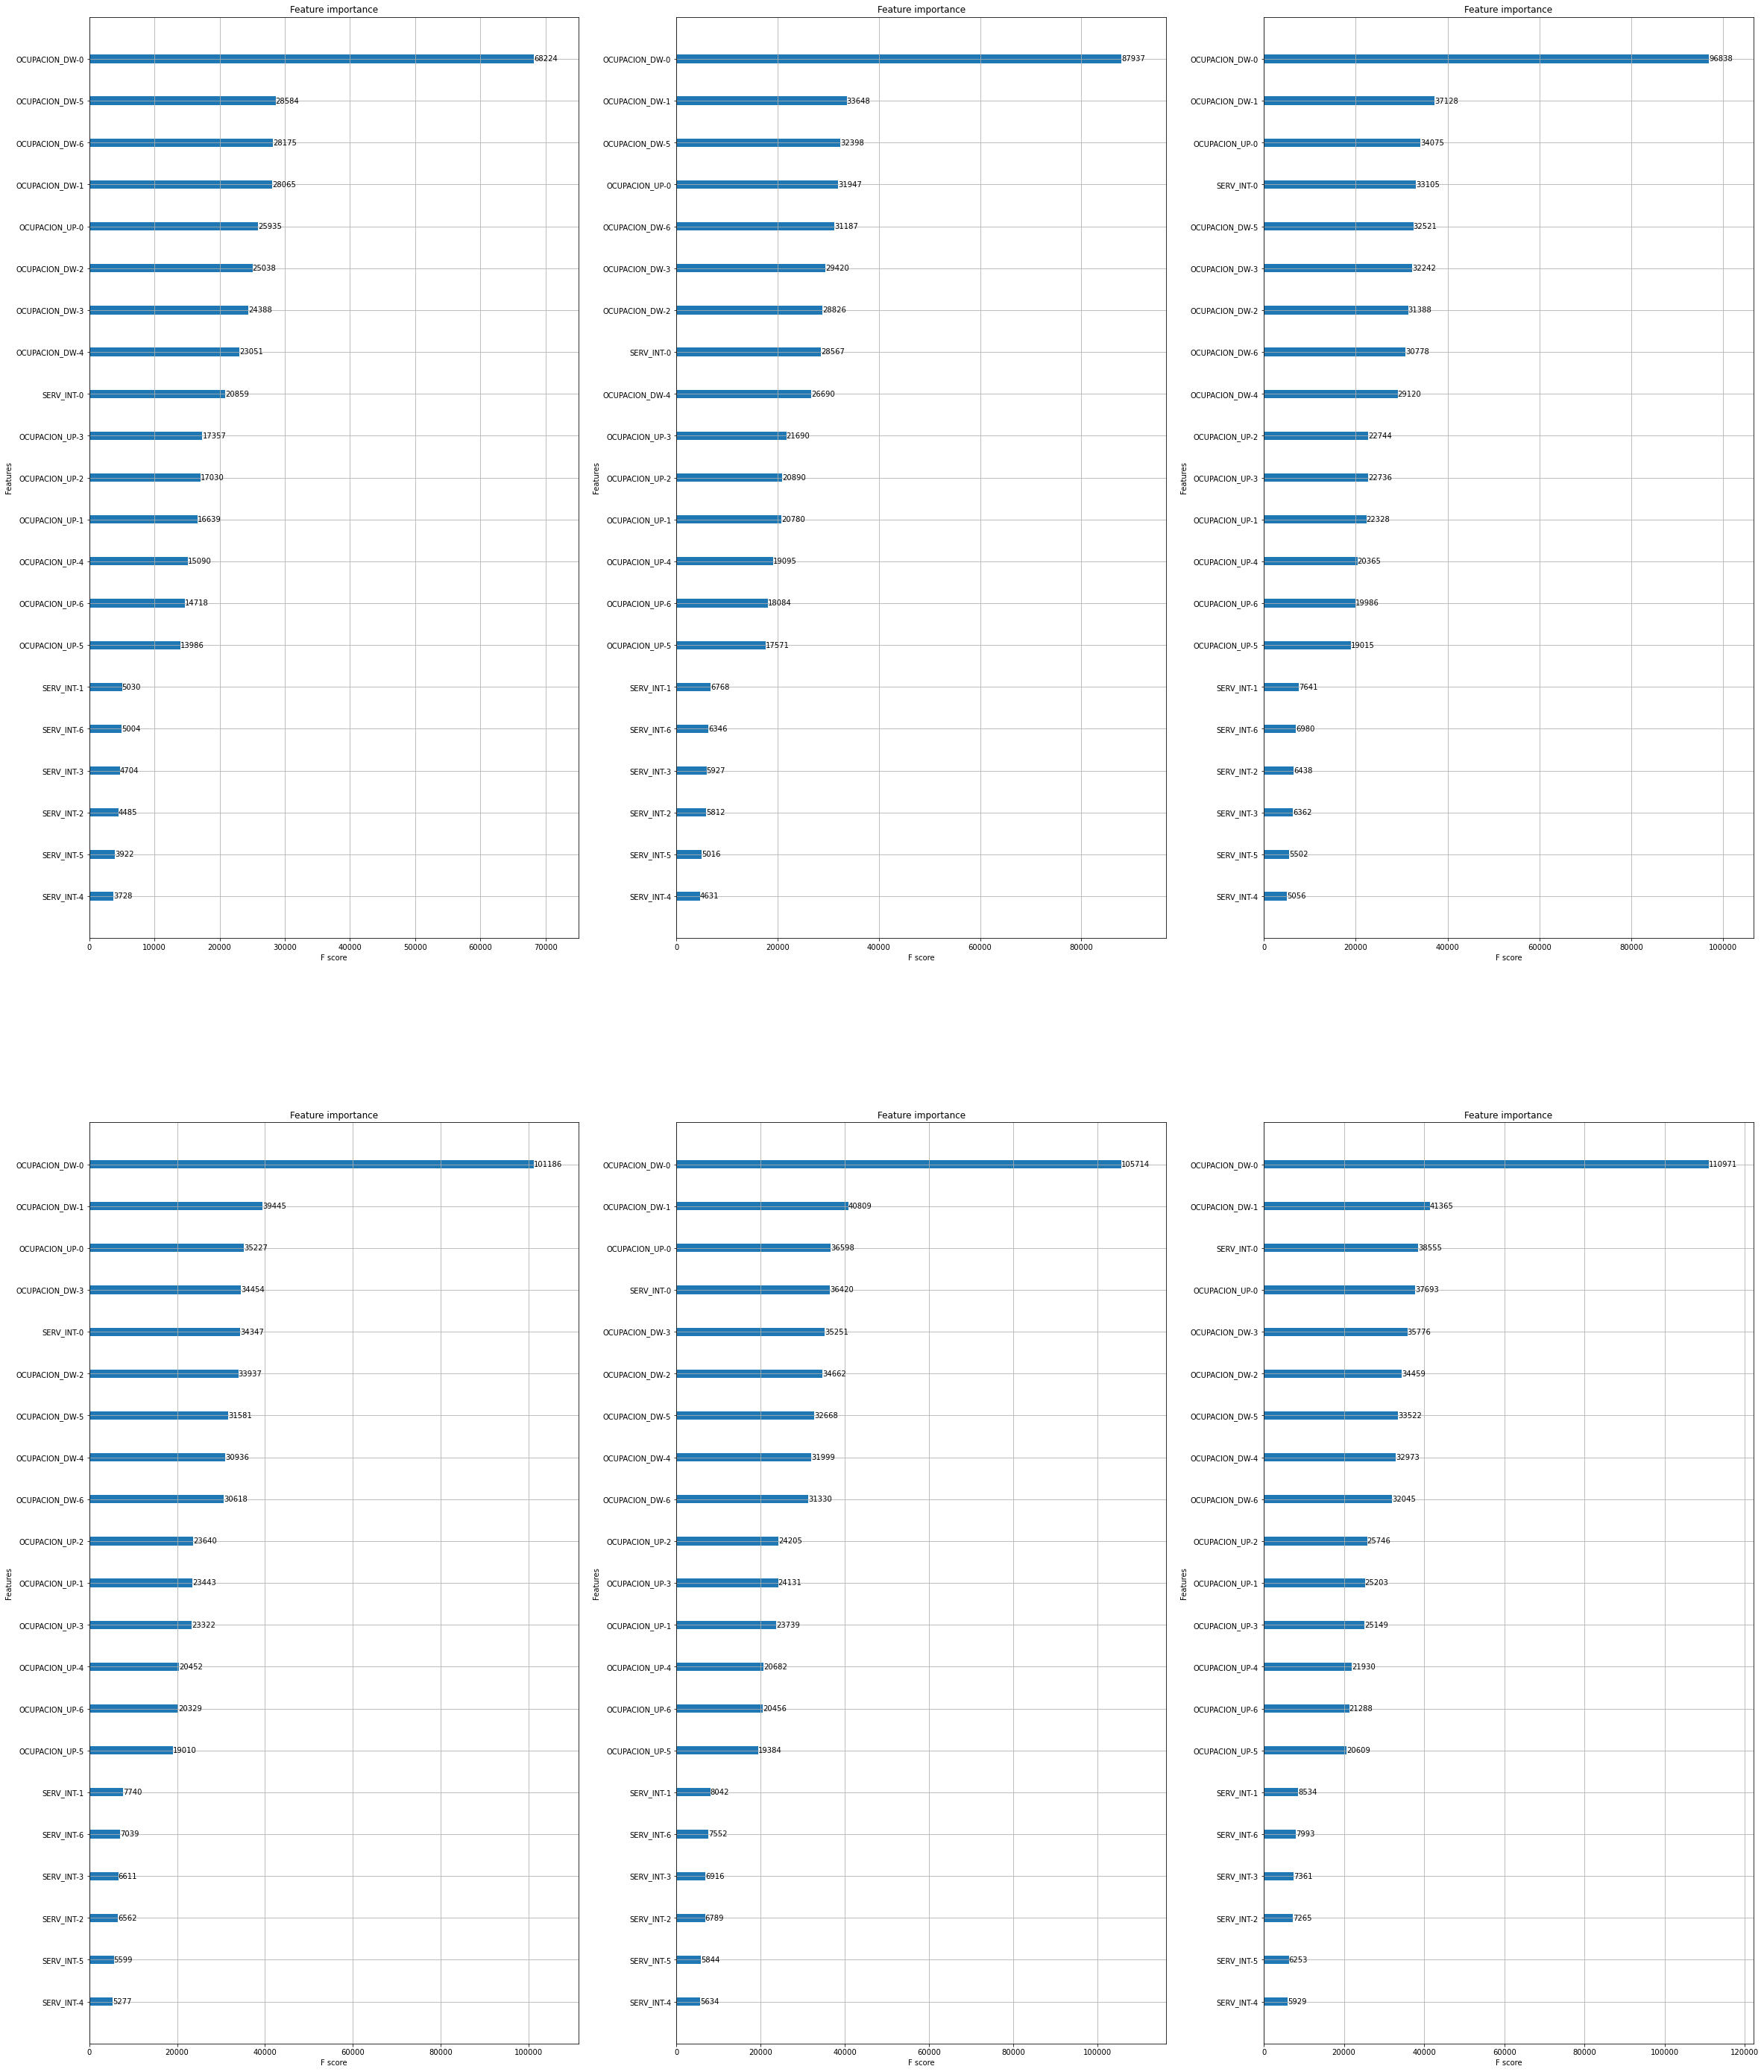

In [96]:
fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(40,50))
i=0
for predVar in modelos:
    j=0    
    axes[i//3,i%3].set_title(predVar)    
    xgb.plot_importance(modelos[predVar]['modelo'],ax=axes[i//3,i%3]) 
    j=j+1
    i=i+1

#### Matrices de confusión

##### Semaforo

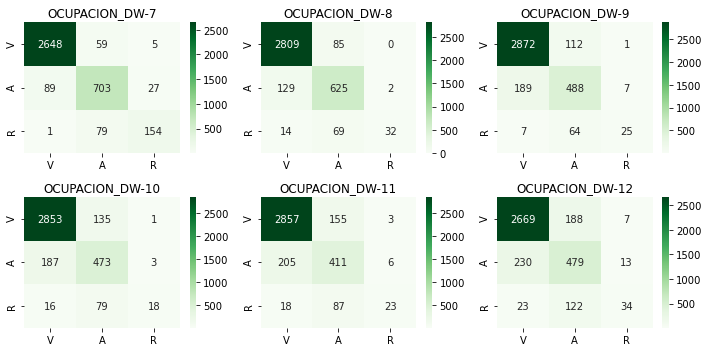

In [97]:
fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(10,5))
i=0
for predVar in modelos:
    y_test_sem = [semaforoVal(x) for x in y_test[predVar]]    
    y_test_p_sem=[semaforoVal(x) for x in modelos[predVar]['predictions']]
    matrizConfucion = confusion_matrix(y_test_sem, y_test_p_sem, labels=['V','A','R'])
    matrizConfucionDF=pd.DataFrame(matrizConfucion, index=['V','A','R'], columns=['V','A','R'])
    sns.heatmap(matrizConfucionDF, annot = True, cmap = 'Greens', fmt='g', ax=axes[i//3,i%3])
    axes[i//3,i%3].set_title(predVar)    
    i=i+1
fig.tight_layout()

#####  Rojos

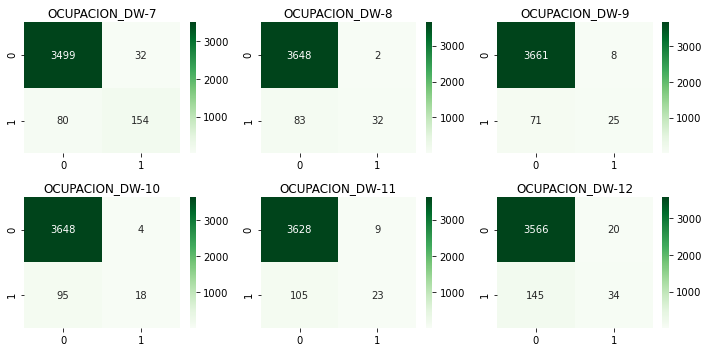

In [98]:
fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(10,5))
i=0
for predVar in modelos:    
    y_test_sem = [semaforoRojo(x) for x in y_test[predVar]]
    y_test_p_sem=[semaforoRojo(x) for x in modelos[predVar]['predictions']]
    matrizConfucion = confusion_matrix(y_test_sem, y_test_p_sem)
    matrizConfucionDF=pd.DataFrame(matrizConfucion)
    sns.heatmap(matrizConfucionDF, annot = True, cmap = 'Greens', fmt='g', ax=axes[i//3,i%3])
    axes[i//3,i%3].set_title(predVar)    
    i=i+1
fig.tight_layout()

##### Curva ROC y AUC

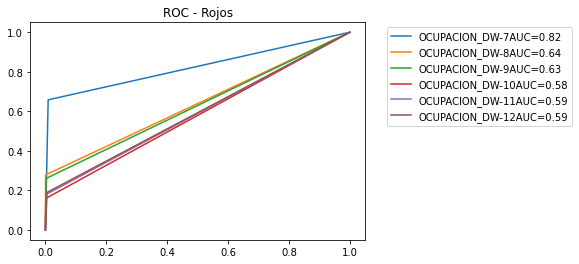

In [99]:
i=0
for predVar in modelos:
    j=0
    y_test_sem = [semaforoRojo(x) for x in y_test[predVar]]
    y_test_p_sem=[semaforoRojo(x) for x in modelos[predVar]['predictions']]
    fpr1, tpr1, _ = roc_curve(y_test_sem, y_test_p_sem)
    auc1 = roc_auc_score(y_test_sem, y_test_p_sem)
    modelos[predVar]['AUC']=auc1
    plt.plot(fpr1, tpr1, label = predVar+'AUC={}'.format(np.round(auc1, 2)))        
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1));
plt.title("ROC - Rojos");

##### ROC AMARILLOS

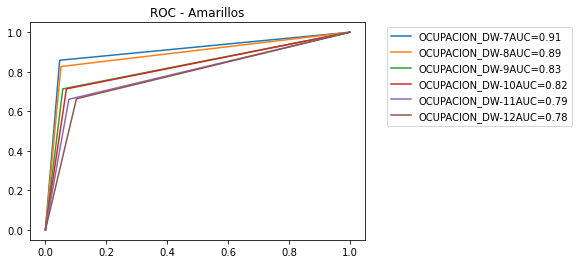

In [100]:
for predVar in modelos:        
    y_test_sem = [semaforoAmarillo(x) for x in y_test[predVar]]
    y_test_p_sem=[semaforoAmarillo(x) for x in modelos[predVar]['predictions']]
    fpr1, tpr1, _ = roc_curve(y_test_sem, y_test_p_sem)
    auc1 = roc_auc_score(y_test_sem, y_test_p_sem)
    modelos[predVar]['AUC']=auc1
    plt.plot(fpr1, tpr1, label = predVar+'AUC={}'.format(np.round(auc1, 2)))            
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1));
plt.title("ROC - Amarillos");

##### ROC Rojos y Amarillos

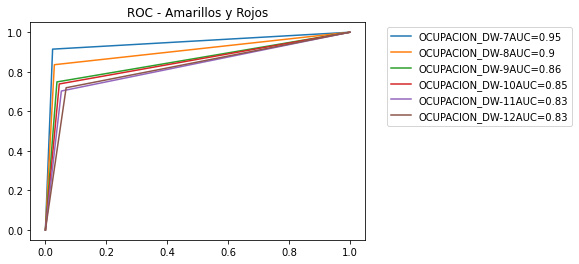

In [101]:
for predVar in modelos:    
    y_test_sem = [semaforoRojoAmarillo(x) for x in y_test[predVar]]
    y_test_p_sem=[semaforoRojoAmarillo(x) for x in modelos[predVar]['predictions']]
    fpr1, tpr1, _ = roc_curve(y_test_sem, y_test_p_sem)
    auc1 = roc_auc_score(y_test_sem, y_test_p_sem)
    modelos[predVar]['AUC']=auc1
    plt.plot(fpr1, tpr1, label = predVar+'AUC={}'.format(np.round(auc1, 2)))           
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1));
plt.title("ROC - Amarillos y Rojos");

### LGBMClassifier

#### Agregar Semaforo a variable y

In [102]:
X_train, X_test, y_train, y_test = train_test_split(XvarC, yvar, test_size = 0.3, random_state = 86, shuffle= True)

In [104]:
X_train.columns.values

array(['CANT_CALL-0', 'CANT_CALL-1', 'CANT_CALL-2', 'CANT_CALL-3',
       'CANT_CALL-4', 'CANT_CALL-5', 'CANT_CALL-6', 'CANT_USER-0',
       'CANT_USER-1', 'CANT_USER-2', 'CANT_USER-3', 'CANT_USER-4',
       'CANT_USER-5', 'CANT_USER-6', 'CONVERGENTE-0', 'CONVERGENTE-1',
       'CONVERGENTE-2', 'CONVERGENTE-3', 'CONVERGENTE-4', 'CONVERGENTE-5',
       'CONVERGENTE-6', 'MEDIANA_VEL-0', 'MEDIANA_VEL-1', 'MEDIANA_VEL-2',
       'MEDIANA_VEL-3', 'MEDIANA_VEL-4', 'MEDIANA_VEL-5', 'MEDIANA_VEL-6',
       'OCUPACION_DW-0', 'OCUPACION_DW-1', 'OCUPACION_DW-2',
       'OCUPACION_DW-3', 'OCUPACION_DW-4', 'OCUPACION_DW-5',
       'OCUPACION_DW-6', 'OCUPACION_UP-0', 'OCUPACION_UP-1',
       'OCUPACION_UP-2', 'OCUPACION_UP-3', 'OCUPACION_UP-4',
       'OCUPACION_UP-5', 'OCUPACION_UP-6', 'PROM_RENTA-0', 'PROM_RENTA-1',
       'PROM_RENTA-2', 'PROM_RENTA-3', 'PROM_RENTA-4', 'PROM_RENTA-5',
       'PROM_RENTA-6', 'PROM_VEL-0', 'PROM_VEL-1', 'PROM_VEL-2',
       'PROM_VEL-3', 'PROM_VEL-4', 'PROM_VEL-5',

In [105]:
modelosClass={}
X_train_Balanceadas={}
for yCol in yColClass:  
    count=y_train[yCol].value_counts()
    n_samples=int(count.max())
    over_sampler = SMOTE(sampling_strategy=sampling_strategy(X_train, y_train[yCol],n_samples,t='minority'),k_neighbors=2)
    X_train_res, y_train_res= over_sampler.fit_resample(X_train,y_train[yCol])
    X_train_Balanceadas[yCol]=X_train_res
    
    print(yCol)
    y_test_aux=y_test[yCol]
    dicModelo={}        
    
    dicModelo['modelo']=LGBMClassifier(n_estimators=500, learning_rate=0.01, reg_alpha=1, reg_lambda=3, objective ='multiclass')
    dicModelo['modelo'].fit(X_train_res, y_train_res) # ajustamos los datos de entrenamiento

    dicModelo['predictions'] =dicModelo['modelo'].predict(X_test)
    dicModelo['explanation']=shap.TreeExplainer(dicModelo['modelo'])
    dicModelo['shap_values']=dicModelo['explanation'].shap_values(XvarC)    
    modelosClass[yCol]=dicModelo

OCUPACION_DW-7_sem2
OCUPACION_DW-8_sem2
OCUPACION_DW-9_sem2
OCUPACION_DW-10_sem2
OCUPACION_DW-11_sem2
OCUPACION_DW-12_sem2


 #### Variables Explicativas

#### Matrices de Confusión

##### Semaforo

OCUPACION_DW-7_sem2
exactitud: 0.9237715803452855
sensibilidad  0 :  0.9671828908554573
especificidad  0 :  0.9183285849952516
sensibilidad  1 :  0.8046398046398047
especificidad  1 :  0.9640190088255262
sensibilidad  2 :  0.8376068376068376
especificidad  2 :  0.97309544038516
OCUPACION_DW-8_sem2
exactitud: 0.90199203187251
sensibilidad  0 :  0.9492052522460263
especificidad  0 :  0.851894374282434
sensibilidad  1 :  0.753968253968254
especificidad  1 :  0.9584579594549685
sensibilidad  2 :  0.6869565217391305
especificidad  2 :  0.9684931506849315
OCUPACION_DW-9_sem2
exactitud: 0.8841965471447543
sensibilidad  0 :  0.9283082077051926
especificidad  0 :  0.8217948717948718
sensibilidad  1 :  0.7558479532163743
especificidad  1 :  0.9302174618630314
sensibilidad  2 :  0.4270833333333333
especificidad  2 :  0.9776505859907332
OCUPACION_DW-10_sem2
exactitud: 0.8557768924302789
sensibilidad  0 :  0.9143526262964202
especificidad  0 :  0.7603092783505154
sensibilidad  1 :  0.65460030165912

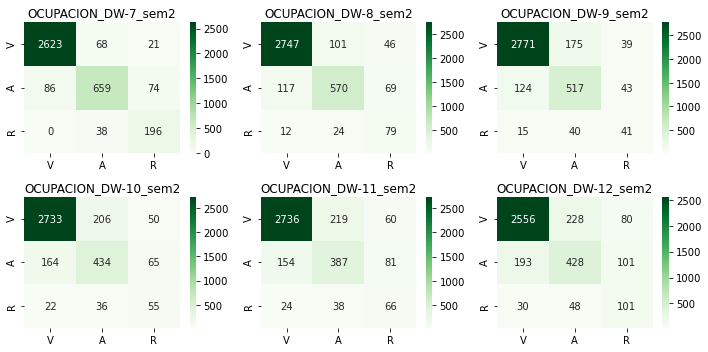

In [106]:
fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(10,5))
i=0
for predVar in modelosClass:        
    y_test_sem = y_test[predVar]
    y_test_p_sem=modelosClass[predVar]['predictions']
    matrizConfucion = confusion_matrix(y_test_sem, y_test_p_sem)
    matrizConfucionDF=pd.DataFrame(matrizConfucion, index=['V','A','R'], columns=['V','A','R'])
    print(predVar)
    medidasEvaluacion(matrizConfucion)
    sns.heatmap(matrizConfucionDF, annot = True, cmap = 'Greens', fmt='g', ax=axes[i//3,i%3])
    axes[i//3,i%3].set_title(predVar)    
    i=i+1
fig.tight_layout()

##### Rojos

OCUPACION_DW-7_sem2
OCUPACION_DW-8_sem2
OCUPACION_DW-9_sem2
OCUPACION_DW-10_sem2
OCUPACION_DW-11_sem2
OCUPACION_DW-12_sem2


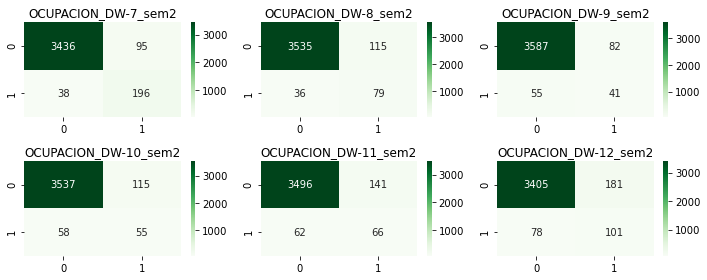

In [107]:
fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(10,4))
i=0
for predVar in modelosClass:  
    print(predVar)
    y_test_sem = [semaforoNum2Rojo(x) for x in y_test[predVar]]
    y_test_p_sem=[semaforoNum2Rojo(x) for x in modelosClass[predVar]['predictions']]
    matrizConfucion = confusion_matrix(y_test_sem, y_test_p_sem)
    matrizConfucionDF=pd.DataFrame(matrizConfucion)
    sns.heatmap(matrizConfucionDF, annot = True, cmap = 'Greens', fmt='g', ax=axes[i//3,i%3])
    axes[i//3,i%3].set_title(predVar)    
    i=i+1
fig.tight_layout()

#####  Curva ROC

##### Solo Rojos

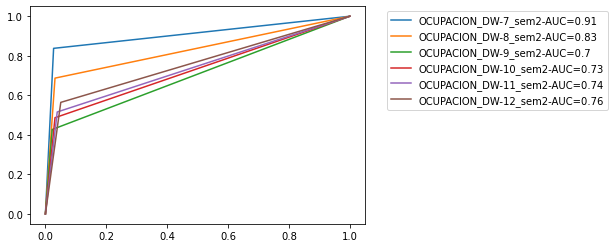

In [108]:
for predVar in modelosClass:        
    y_test_sem = [semaforoNum2Rojo(x) for x in y_test[predVar]]
    y_test_p_sem=[semaforoNum2Rojo(x) for x in modelosClass[predVar]['predictions']]
    fpr1, tpr1, _ = roc_curve(y_test_sem, y_test_p_sem)
    auc1 = roc_auc_score(y_test_sem, y_test_p_sem)
    modelosClass[predVar]['AUC']=auc1
    plt.plot(fpr1, tpr1, label = predVar+'-'+'AUC={}'.format(np.round(auc1, 2)))            
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1));

##### Solo Amarillos

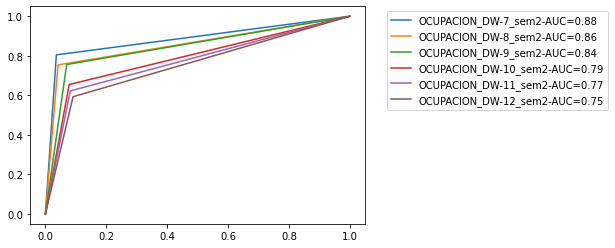

In [109]:
for predVar in modelosClass:        
    y_test_sem = [semaforoNum2Amarillo(x) for x in y_test[predVar]]
    y_test_p_sem=[semaforoNum2Amarillo(x) for x in modelosClass[predVar]['predictions']]
    fpr1, tpr1, _ = roc_curve(y_test_sem, y_test_p_sem)
    auc1 = roc_auc_score(y_test_sem, y_test_p_sem)
    modelosClass[predVar]['AUC']=auc1
    plt.plot(fpr1, tpr1, label = predVar+'-'+'AUC={}'.format(np.round(auc1, 2)))            
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1));

##### Rojos y amarillos

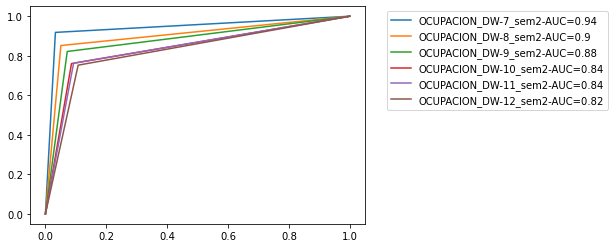

In [110]:
for predVar in modelosClass:        
    y_test_sem = [semaforoNum2RojoAmarillo(x) for x in y_test[predVar]]
    y_test_p_sem=[semaforoNum2RojoAmarillo(x) for x in modelosClass[predVar]['predictions']]
    fpr1, tpr1, _ = roc_curve(y_test_sem, y_test_p_sem)
    auc1 = roc_auc_score(y_test_sem, y_test_p_sem)
    modelosClass[predVar]['AUC']=auc1
    plt.plot(fpr1, tpr1, label = predVar+'-'+'AUC={}'.format(np.round(auc1, 2)))            
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1));

###  NUEVAS PREDICCIONES

In [111]:
data_ocupacionNp=data_ocupacion.copy()
data_ocupacionNpC=data_ocupacionC.copy()

In [112]:
periodos_x=6
fechaMaxima=data_ocupacionNp['FECHA'].max()
fechaInicialNp=fechaMaxima + relativedelta(months=-1*periodos_x)

In [113]:
data_ocupacionNp=data_ocupacionNp[data_ocupacionNp['FECHA']>=fechaInicialNp]
data_ocupacionNpC=data_ocupacionNpC[data_ocupacionNpC['FECHA']>=fechaInicialNp]
data_ocupacionNp['mesAnt']=(periodos_x)-diff_month(fechaMaxima,data_ocupacionNp['FECHA'])
data_ocupacionNpC['mesAnt']=(periodos_x)-diff_month(fechaMaxima,data_ocupacionNpC['FECHA'])

In [114]:
data_ocupacionNp['FECHA'].max()

Timestamp('2021-11-01 00:00:00')

In [115]:
data_ocupacionNp['FECHA'].min()

Timestamp('2021-05-01 00:00:00')

In [116]:
colsNp=data_ocupacionNp.columns
colsNp=colsNp[2:-1]
colsNpC=data_ocupacionNpC.columns
colsNpC=colsNpC[2:-1]

In [117]:
#Tabla para regresión
cols_xNp=[]
for i, col in enumerate(colsNp):
    tablaAnalisisNp = pd.pivot_table(data_ocupacionNp.reset_index(), index='COD_NODO', columns='mesAnt', values=col)
    tablaAnalisisNp.rename(columns={x: (col+"-"+str(x)) for x in tablaAnalisisNp.columns}, inplace=True)    
    cols_xNp=cols_xNp+[(col+"-"+str(x)) for x in range(0,periodos_x+1)]    
    if i==0:
        tablaAnalisisTotalNp = tablaAnalisisNp
    else:
        tablaAnalisisTotalNp = tablaAnalisisTotalNp.merge(tablaAnalisisNp, how='outer', on='COD_NODO')

In [118]:
#Tabla para clasificación
cols_xNpC=[]
for i, col in enumerate(colsNpC):
    tablaAnalisisNpC = pd.pivot_table(data_ocupacionNpC.reset_index(), index='COD_NODO', columns='mesAnt', values=col)
    tablaAnalisisNpC.rename(columns={x: (col+"-"+str(x)) for x in tablaAnalisisNpC.columns}, inplace=True)    
    cols_xNpC=cols_xNpC+[(col+"-"+str(x)) for x in range(0,periodos_x+1)]    
    if i==0:
        tablaAnalisisTotalNpC = tablaAnalisisNpC
    else:
        tablaAnalisisTotalNpC = tablaAnalisisTotalNpC.merge(tablaAnalisisNpC, how='outer', on='COD_NODO')

In [119]:
tablaAnalisisTotalNp=tablaAnalisisTotalNp.dropna()
tablaAnalisisTotalNpC=tablaAnalisisTotalNpC.dropna()

In [120]:
tablaResultados=tablaAnalisisTotalNp.copy()

#### Resultados 

In [121]:
for predVar in modelos:
    print(predVar)
    tablaResultados[predVar+'_pR']=modelos[predVar]['modelo'].predict(tablaAnalisisTotalNp[cols_x])
    tablaResultados[predVar+'_pR_Sem']=tablaResultados[predVar+'_pR'].apply(semaforoVal)    

OCUPACION_DW-7
OCUPACION_DW-8
OCUPACION_DW-9
OCUPACION_DW-10
OCUPACION_DW-11
OCUPACION_DW-12


In [122]:
for predVar in modelosClass:
    print(predVar)
    tablaResultados[predVar+'_pC']=modelosClass[predVar]['modelo'].predict(tablaAnalisisTotalNpC[cols_xC])
    tablaResultados[predVar+'_pC']=tablaResultados[predVar+'_pC'].apply(semaforoNum2Val)    

OCUPACION_DW-7_sem2
OCUPACION_DW-8_sem2
OCUPACION_DW-9_sem2
OCUPACION_DW-10_sem2
OCUPACION_DW-11_sem2
OCUPACION_DW-12_sem2


In [123]:
import pandas as pd
pd.set_option('display.max_columns', None)
tablaResultados.head(10)

mesAnt,OCUPACION_DW-0,OCUPACION_DW-1,OCUPACION_DW-2,OCUPACION_DW-3,OCUPACION_DW-4,OCUPACION_DW-5,OCUPACION_DW-6,OCUPACION_UP-0,OCUPACION_UP-1,OCUPACION_UP-2,OCUPACION_UP-3,OCUPACION_UP-4,OCUPACION_UP-5,OCUPACION_UP-6,SERV_INT-0,SERV_INT-1,SERV_INT-2,SERV_INT-3,SERV_INT-4,SERV_INT-5,SERV_INT-6,OCUPACION_DW-7_pR,OCUPACION_DW-7_pR_Sem,OCUPACION_DW-8_pR,OCUPACION_DW-8_pR_Sem,OCUPACION_DW-9_pR,OCUPACION_DW-9_pR_Sem,OCUPACION_DW-10_pR,OCUPACION_DW-10_pR_Sem,OCUPACION_DW-11_pR,OCUPACION_DW-11_pR_Sem,OCUPACION_DW-12_pR,OCUPACION_DW-12_pR_Sem,OCUPACION_DW-7_sem2_pC,OCUPACION_DW-8_sem2_pC,OCUPACION_DW-9_sem2_pC,OCUPACION_DW-10_sem2_pC,OCUPACION_DW-11_sem2_pC,OCUPACION_DW-12_sem2_pC
COD_NODO,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
01J,0.362382,0.337471,0.350570,0.314207,0.332251,0.319572,0.326798,0.211418,0.220097,0.233507,0.257879,0.232684,0.179844,0.246624,26.0,25.0,24.0,23.0,24.0,24.0,24.0,0.345000,V,0.332352,V,0.312772,V,0.340284,V,0.348542,V,0.353710,V,V,V,V,V,V,V
01S,0.373240,0.348979,0.432986,0.404191,0.379371,0.394562,0.422378,0.339117,0.306406,0.269256,0.287102,0.310938,0.346350,0.312825,171.0,170.0,177.0,175.0,186.0,184.0,177.0,0.441919,V,0.427269,V,0.416502,V,0.419593,V,0.422132,V,0.460034,V,V,V,V,V,V,V
02J,0.362382,0.337471,0.350570,0.314207,0.332251,0.319572,0.326798,0.211418,0.220097,0.233507,0.257879,0.232684,0.179844,0.246624,13.0,14.0,15.0,13.0,12.0,11.0,12.0,0.342924,V,0.330209,V,0.312456,V,0.339330,V,0.346802,V,0.347693,V,V,V,V,V,V,V
02S,0.373240,0.348979,0.432986,0.404191,0.379371,0.394562,0.422378,0.301526,0.243914,0.227977,0.228819,0.247392,0.231056,0.270342,148.0,144.0,148.0,162.0,162.0,147.0,144.0,0.436251,V,0.427876,V,0.418020,V,0.412242,V,0.412562,V,0.441515,V,V,V,V,V,V,V
03J,0.362382,0.337471,0.350570,0.314207,0.332251,0.319572,0.326798,0.211418,0.220097,0.233507,0.257879,0.232684,0.179844,0.246624,32.0,32.0,30.0,29.0,29.0,28.0,26.0,0.344495,V,0.332692,V,0.315154,V,0.342419,V,0.345385,V,0.361446,V,V,V,V,V,V,V
04J,0.362382,0.337471,0.350570,0.314207,0.332251,0.319572,0.326798,0.211418,0.220097,0.233507,0.257879,0.232684,0.179844,0.246624,19.0,21.0,20.0,20.0,20.0,18.0,18.0,0.344972,V,0.332593,V,0.314478,V,0.341004,V,0.344768,V,0.347957,V,V,V,V,V,V,V
05J,0.302036,0.318871,0.289796,0.289193,0.260464,0.288334,0.278748,0.274566,0.257956,0.237106,0.280441,0.264702,0.325102,0.305621,60.0,60.0,61.0,58.0,57.0,54.0,50.0,0.283072,V,0.281612,V,0.295971,V,0.310795,V,0.309362,V,0.305018,V,V,V,V,V,V,V
06J,0.302036,0.318871,0.289796,0.289193,0.260464,0.288334,0.278748,0.274566,0.257956,0.237106,0.280441,0.264702,0.325102,0.305621,40.0,40.0,39.0,37.0,37.0,37.0,39.0,0.282794,V,0.283422,V,0.291517,V,0.311626,V,0.310122,V,0.306676,V,V,V,V,V,V,V
07J,0.302036,0.318871,0.289796,0.289193,0.260464,0.288334,0.278748,0.274566,0.257956,0.237106,0.280441,0.264702,0.325102,0.305621,49.0,45.0,47.0,47.0,48.0,47.0,46.0,0.283761,V,0.282646,V,0.292695,V,0.311711,V,0.309537,V,0.305460,V,V,V,V,V,V,V


####  Ranking de Nodos

In [124]:
reglasRank = [[0 , 0.2, 0.6],[0.2 , 0.4, 0.8],[0.6, 0.8, 1]]

In [125]:
def valRank(predR,predC):    
    return reglasRank[predR][predC]

In [126]:
for predVar in modelos:    
    tablaResultados[predVar+'v1']=tablaResultados[predVar+'_pR_Sem'].apply(semaforoVal2Num)
    tablaResultados[predVar+'v2']=tablaResultados[predVar+'_sem2_pC'].apply(semaforoVal2Num)    
    tablaResultados[predVar+'_Rank'] = tablaResultados.apply(lambda x: valRank(x[predVar+'v1'],x[predVar+'v2']), axis=1)    

In [127]:
## ordernar columnas
columnasResultados=[]
for predVar in modelos: 
    auxCol=[predVar+'_pR',predVar+'_pR_Sem',predVar+'_sem2_pC',predVar+'_Rank']
    columnasResultados=columnasResultados+auxCol

In [128]:
### No se guardan las predicciones,  se ejecuta el script para predecir
## tablaResultados[columnasResultados].to_csv('Resultados/resultadosVp.csv', index=True,sep=';')

In [129]:
end = datetime.now()
print(f'Tiempo: {end - start} segundos')

Tiempo: 0:19:43.699969 segundos


### Guardar Modelos

In [130]:
gModeloR={}
for yCol in cols_y:
    gModeloR[yCol]=modelos[yCol]['modelo']

gModeloC={}
for yCol in yColClass:
    gModeloC[yCol]=modelosClass[yCol]['modelo']

In [131]:
ruta_modelo = f"modeloR.pkl"
dump(gModeloR, ruta_modelo)

['modeloR.pkl']

In [132]:
ruta_modelo = f"modeloC.pkl"
dump(gModeloC, ruta_modelo)

['modeloC.pkl']

### Ajuste Umbrales

In [133]:
TablaRx=['OCUPACION_DW-0','OCUPACION_DW-1','OCUPACION_DW-2','OCUPACION_DW-3','OCUPACION_DW-4','OCUPACION_DW-5','OCUPACION_DW-6','OCUPACION_DW-7_pR','OCUPACION_DW-8_pR','OCUPACION_DW-9_pR','OCUPACION_DW-10_pR','OCUPACION_DW-11_pR','OCUPACION_DW-12_pR']

In [134]:
tablaUmbral=tablaResultados[TablaRx]
tablaUmbral.columns=[x for x in range(0,13)]
tablaUmbral

,0,1,2,3,4,5,6,7,8,9,10,11,12
COD_NODO,,,,,,,,,,,,,
01J,0.362382,0.337471,0.350570,0.314207,0.332251,0.319572,0.326798,0.345000,0.332352,0.312772,0.340284,0.348542,0.353710
01S,0.373240,0.348979,0.432986,0.404191,0.379371,0.394562,0.422378,0.441919,0.427269,0.416502,0.419593,0.422132,0.460034
02J,0.362382,0.337471,0.350570,0.314207,0.332251,0.319572,0.326798,0.342924,0.330209,0.312456,0.339330,0.346802,0.347693
02S,0.373240,0.348979,0.432986,0.404191,0.379371,0.394562,0.422378,0.436251,0.427876,0.418020,0.412242,0.412562,0.441515
03J,0.362382,0.337471,0.350570,0.314207,0.332251,0.319572,0.326798,0.344495,0.332692,0.315154,0.342419,0.345385,0.361446
...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZVD,0.630313,0.536716,0.614113,0.541626,0.561283,0.605098,0.540601,0.561631,0.516944,0.547829,0.531688,0.530060,0.560084
ZVG,0.288601,0.265490,0.294397,0.318416,0.268962,0.311872,0.385325,0.366329,0.339935,0.352537,0.333420,0.326070,0.327750
ZVS,0.352078,0.294876,0.286604,0.309174,0.301405,0.330338,0.388761,0.377400,0.363157,0.352595,0.363845,0.349620,0.395775


In [135]:
pd.melt(tablaUmbral) 

,variable,value
0,0,0.362382
1,0,0.373240
2,0,0.362382
3,0,0.373240
4,0,0.362382
...,...,...
165758,12,0.560084
165759,12,0.327750
165760,12,0.395775
165761,12,0.493635


In [136]:
tablaHumbral2=pd.melt(tablaUmbral)

In [137]:
tablaHumbral2['rojo']=np.where(tablaHumbral2['value'] >= 0.8,1,0)
tablaHumbral2['amarillo']=np.where((tablaHumbral2['value'] >= 0.6) & (tablaHumbral2['value'] < 0.8),1,0)
tablaHumbral2     

,variable,value,rojo,amarillo
0,0,0.362382,0,0
1,0,0.373240,0,0
2,0,0.362382,0,0
3,0,0.373240,0,0
4,0,0.362382,0,0
...,...,...,...,...
165758,12,0.560084,0,0
165759,12,0.327750,0,0
165760,12,0.395775,0,0
165761,12,0.493635,0,0


In [138]:
tablaHumbralRojos=pd.pivot_table(tablaHumbral2.reset_index(), index='variable', columns='rojo', values='index', aggfunc=lambda x:len(x.unique()))
tablaHumbralRojos['%_Rojos']=100*tablaHumbralRojos[1]/(tablaHumbralRojos[0]+tablaHumbralRojos[1])
tablaHumbralRojos
# aqui vemos los porcentajes de rojos en cada mes

rojo,0,1,%_Rojos
variable,,,
0,12392.0,359.0,2.815465
1,12557.0,194.0,1.521449
2,12622.0,129.0,1.011685
3,12600.0,151.0,1.184221
4,12538.0,213.0,1.670457
5,12435.0,316.0,2.478237
6,12468.0,283.0,2.219434
7,12698.0,53.0,0.415654
8,12741.0,10.0,0.078425


###  Definición Umbral Rojos

In [139]:
tablaHumbralRojos.loc[:6].describe()

rojo,0,1,%_Rojos
count,7.000000,7.000000,7.000000
mean,12516.000000,235.000000,1.842993
std,86.311452,86.311452,0.676899
min,12392.000000,129.000000,1.011685
25%,12451.500000,172.500000,1.352835
50%,12538.000000,213.000000,1.670457
75%,12578.500000,299.500000,2.348835
max,12622.000000,359.000000,2.815465


In [140]:
tablaHumbralRojos.loc[6:].describe()

rojo,0,1,%_Rojos
count,7.000000,5.000000,5.000000
mean,12700.285714,71.000000,0.556819
std,104.121266,120.255977,0.943110
min,12468.000000,2.000000,0.015685
25%,12719.500000,7.000000,0.054898
50%,12744.000000,10.000000,0.078425
75%,12750.000000,53.000000,0.415654
max,12751.000000,283.000000,2.219434


<AxesSubplot:xlabel='variable'>

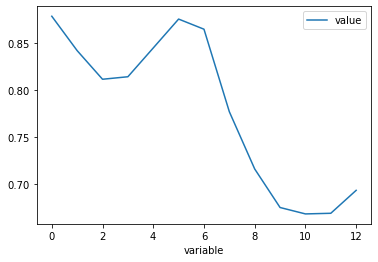

In [141]:
tablaHumbral2.groupby('variable').quantile(1-0.008778)[['value']].plot()
# vemos la variacion del porcentaje de rojos

<AxesSubplot:xlabel='variable'>

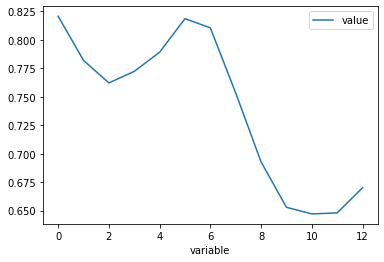

In [142]:
tablaHumbral2.groupby('variable').quantile(1-0.01971)[['value']].plot()

###  Definión umbral Amarillos

In [143]:
tablaHumbralAmarillos=pd.pivot_table(tablaHumbral2.reset_index(), index='variable', columns='amarillo', values='index', aggfunc=lambda x:len(x.unique()))
tablaHumbralAmarillos['%_Amarilos']=100*tablaHumbralAmarillos[1]/(tablaHumbralAmarillos[0]+tablaHumbralAmarillos[1])
tablaHumbralAmarillos

amarillo,0,1,%_Amarilos
variable,,,
0,9989,2762,21.661046
1,10461,2290,17.959376
2,10738,2013,15.786997
3,10670,2081,16.320289
4,10791,1960,15.371343
5,10411,2340,18.351502
6,10511,2240,17.567250
7,10049,2702,21.190495
8,10748,2003,15.708572


In [144]:
tablaHumbralAmarillos.loc[:6].describe()

amarillo,0,1,%_Amarilos
count,7.000000,7.000000,7.000000
mean,10510.142857,2240.857143,17.573972
std,270.859391,270.859391,2.124221
min,9989.000000,1960.000000,15.371343
25%,10436.000000,2047.000000,16.053643
50%,10511.000000,2240.000000,17.567250
75%,10704.000000,2315.000000,18.155439
max,10791.000000,2762.000000,21.661046


In [145]:
tablaHumbralAmarillos.loc[6:].describe()

amarillo,0,1,%_Amarilos
count,7.000000,7.000000,7.000000
mean,11052.571429,1698.428571,13.319964
std,628.561548,628.561548,4.929508
min,10049.000000,1084.000000,8.501294
25%,10629.500000,1166.500000,9.148302
50%,11224.000000,1527.000000,11.975531
75%,11584.500000,2121.500000,16.637911
max,11667.000000,2702.000000,21.190495


In [146]:
tablaHumbral2.groupby('variable').quantile(1-0.175)[['value']].loc[6:].describe()

,value
count,7.000000
mean,0.582349
std,0.029170
min,0.554803
25%,0.559108
50%,0.571823
75%,0.602555
max,0.626493


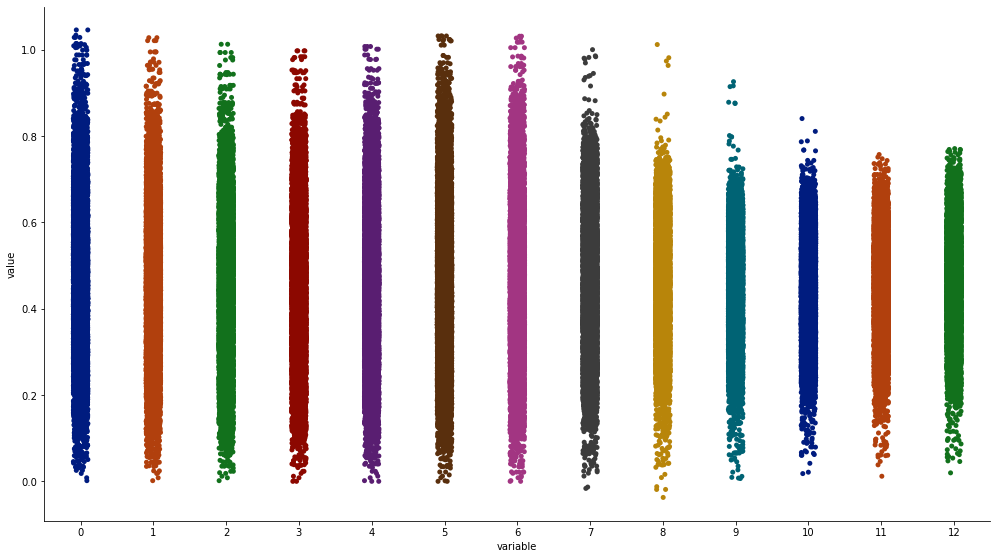

In [147]:
g=sns.catplot(y='value', x='variable', palette="dark", data=pd.melt(tablaUmbral))
g.fig.set_size_inches(15,8)

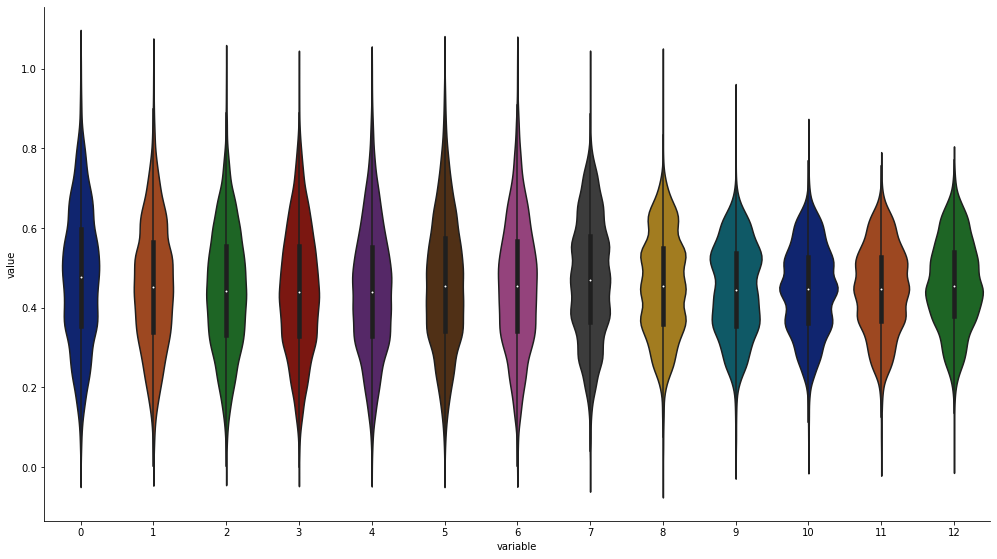

In [148]:
g=sns.catplot(y='value', x='variable', kind="violin", palette="dark", data=pd.melt(tablaUmbral))
g.fig.set_size_inches(15,8)

In [149]:
tablaResultados[TablaRx].describe().T

,count,mean,std,min,25%,50%,75%,max
mesAnt,,,,,,,,
OCUPACION_DW-0,12751.0,0.477606,0.171426,0.001550,0.353006,0.477714,0.596981,1.045716
OCUPACION_DW-1,12751.0,0.455129,0.159886,0.001551,0.339155,0.452286,0.564935,1.027768
OCUPACION_DW-2,12751.0,0.444433,0.155712,0.001541,0.331052,0.441326,0.554624,1.012541
OCUPACION_DW-3,12751.0,0.444756,0.159033,0.000000,0.328327,0.439657,0.555323,0.997289
OCUPACION_DW-4,12751.0,0.444897,0.161113,0.000000,0.328787,0.440513,0.553219,1.007341
OCUPACION_DW-5,12751.0,0.461951,0.166735,0.000000,0.342054,0.455170,0.574414,1.031699
OCUPACION_DW-6,12751.0,0.458838,0.163997,0.000000,0.341772,0.455281,0.568763,1.031143
OCUPACION_DW-7_pR,12751.0,0.470955,0.150719,-0.016390,0.363727,0.470262,0.579918,1.000058
OCUPACION_DW-8_pR,12751.0,0.454945,0.129082,-0.037292,0.358568,0.453572,0.549141,1.011880
